## Steer Function Comparison
In this notebook, we examine the planners using different steer functions.

In [1]:
%load_ext autoreload
%autoreload 2
from mpb import MPB, MultipleMPB
from plot_stats import plot_planner_stats, plot_smoother_stats
from utils import latexify
from table import latex_table
from definitions import *
import matplotlib as mpl
import sys, os
mpl.rcParams['mathtext.fontset'] = 'cm'
# make sure to not use Level-3 fonts
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
from copy import deepcopy
from trajectory import visualize_grid
%config InlineBackend.figure_format='retina'

### Polygon Environments

In [2]:
time_limit_multiplier = 1
steer_function_times = [
    ('reeds_shepp', 15 * time_limit_multiplier),    
    ('dubins', 45 * time_limit_multiplier),    
    ('cc_reeds_shepp', 1.5 * 60 * time_limit_multiplier),    
    ('posq', 120 * time_limit_multiplier)
]

In [3]:
pools = {}
def benchmark_polygon(scenario: str, start: {str: float}, goal: {str: float}, robot_model: str = None):
    bench = "polygon_%s" % scenario
    
    pool = MultipleMPB()
    for steer_function, time_limit in steer_function_times:
        m = MPB()
        m["max_planning_time"] = time_limit
        m["env.start"] = start
        m["env.goal"] = goal
        m["env.type"] = "polygon"
        m["env.polygon.source"] = "polygon_mazes/%s.svg" % scenario[:-2]
        if robot_model:
            print("Using robot model %s." % robot_model)
            m["env.collision.robot_shape_source"] = robot_model
        m["benchmark.planning.sbpl_adstar"] = False
        m["benchmark.planning.sbpl_anastar"] = False
        m["benchmark.planning.sbpl_arastar"] = False
        m["benchmark.planning.sbpl_lazy_ara"] = False
        m["benchmark.planning.sbpl_mha"] = False
        m.set_steer_functions([steer_function])
        pool.benchmarks.append(m)
    pools[scenario] = pool
    run_result = pool.run_parallel(bench, processes=20, limit_memory=True)
    pool.merge(bench + "_total.json", make_separate_runs=True)
    return run_result

In [4]:
def generate_plots(scenario: str, steer_function: int):
    bench = "polygon_%s" % scenario
    steer_function_name = steer_function_times[steer_function][0]
    mpbs = [pool.benchmarks[steer_function] for pool_name, pool in pools.items() if pool_name.startswith(scenario)]
    total_name = "%s_total.json" % scenario
    MPB.merge(mpbs, total_name, make_separate_runs=True)
    bench_steer = "%s_%s" % (bench, steer_function_name)

    # plot planner stats
    try:        
        plot_planner_stats(total_name,
                           save_file="%s/%s_stats.pdf" % (bench, bench_steer),
                           max_plots_per_line=5,
                           metrics='path_length, curvature, planning_time, cusps, aggregate')
    except Exception as e:
        print("Error while plotting planner statistics:", e, file=sys.stderr)

Define 5 different start/goal configurations per polygon environment.

In [5]:
scenarios = [
    (
        "parking1", [
            ({"theta": 0, "x": 0, "y": -2.27}, {"theta": -1.58, "x": 7.72, "y": -7.72}),
            ({"theta": -1.58, "x": 7.72, "y": -7.72}, {"theta": 3.14, "x": 0, "y": -2.27}),
            ({"theta": -1.58, "x": 7.72, "y": -7.72}, {"theta": 1.58, "x": 10, "y": -7.72}),
            ({"theta": -1.58, "x": 7.72, "y": -7.72}, {"theta": 0, "x": 15, "y": -2.27}),
            ({"theta": 3.14, "x": 15, "y": -2.27}, {"theta": -1.58, "x": 7.72, "y": -7.72}),
        ]
    ), (
        "parking2", [
            ({"theta": 0, "x": 0, "y": -2.27}, {"theta": 1.57, "x": 10.91, "y": 2.73}),
            ({"theta": 1.57, "x": 10.91, "y": 2.73}, {"theta": 3.14, "x": 0, "y": -2.27}),
            ({"theta": 0, "x": 0, "y": -2.27}, {"theta": 1.57, "x": 13.5, "y": -7}),
            ({"theta": 1.57, "x": 13.5, "y": -7}, {"theta": 3.14, "x": 0, "y": -2.27}),
            ({"theta": 1.57, "x": 13.5, "y": -7}, {"theta": 1.57, "x": 10.91, "y": 2.73}),
        ]
    ), (
        "parking3", [
            ({"theta": 0, "x": 15.45, "y": -2.27}, {"theta": 0, "x": 3.4, "y": 0.34}),
            ({"theta": 0, "x": 5, "y": -2.27}, {"theta": 0, "x": 19.5, "y": -6}),
            ({"theta": 3.14, "x": 19.5, "y": -6}, {"theta": 3.14, "x": 5, "y": -2.27}),
            ({"theta": 3.14, "x": 19.5, "y": -2.5}, {"theta": 3.14, "x": 4.5, "y": 0.5}),
            ({"theta": 0, "x": 4.5, "y": 0.5}, {"theta": 0, "x": 19.5, "y": -2.5}),
        ]
    ), (
        "warehouse", [
            ({"theta": -1.58, "x": -2.5, "y": 4.55}, {"theta": -1.58, "x": 65, "y": 2.5}, "polygon_mazes/warehouse_robot.svg"),
            ({"theta": 0, "x": -2.5, "y": -55}, {"theta": 0, "x": 55, "y": 5.5}, "polygon_mazes/warehouse_robot.svg"),
            ({"theta": 1.58, "x": 14.5, "y": -28}, {"theta": 1.58, "x": 48, "y": -28}, "polygon_mazes/warehouse_robot.svg"),
            ({"theta": 3.14, "x": 65, "y": -55}, {"theta": 1.58, "x": 14.5, "y": 0}, "polygon_mazes/warehouse_robot.svg"),
            ({"theta": 3.14, "x": 3, "y": -5}, {"theta": 1.58, "x": 66, "y": -5}, "polygon_mazes/warehouse_robot.svg"),
        ]
    )
]

### Run benchmarks
For each steer function, run planners on 4 different polygon environments with 5 different start/goal configurations.

Available memory: 50.67 GB, limiting each MPB process to 20.8% usage (10.56 GB).
Creating pool of 4 processes.
Running MPB with ID polygon_parking1_0_0 (log file at polygon_parking1_0/polygon_parking1_0_0.log)...Running MPB with ID polygon_parking1_0_1 (log file at polygon_parking1_0/polygon_parking1_0_1.log)...Running MPB with ID polygon_parking1_0_3 (log file at polygon_parking1_0/polygon_parking1_0_3.log)...Running MPB with ID polygon_parking1_0_2 (log file at polygon_parking1_0/polygon_parking1_0_2.log)...





polygon_parking1_0_0:   0%|          | 0/22 [00:00<?, ?it/s]

polygon_parking1_0_3:   0%|          | 0/22 [00:00<?, ?it/s]

polygon_parking1_0_1:   0%|          | 0/22 [00:00<?, ?it/s]

polygon_parking1_0_2:   0%|          | 0/22 [00:00<?, ?it/s]

Benchmark 1 (polygon_parking1_0_1) finished successfully.
Benchmark 3 (polygon_parking1_0_3) finished successfully.
Benchmark 0 (polygon_parking1_0_0) finished successfully.
Benchmark 2 (polygon_parking1_0_2) finished successfully.
All benchmarks succeeded.
Successfully merged [polygon_parking1_0/polygon_parking1_0_0_results.json, polygon_parking1_0/polygon_parking1_0_1_results.json, polygon_parking1_0/polygon_parking1_0_2_results.json, polygon_parking1_0/polygon_parking1_0_3_results.json] into polygon_parking1_0_total.json.
Available memory: 50.65 GB, limiting each MPB process to 20.8% usage (10.55 GB).
Creating pool of 4 processes.
Running MPB with ID polygon_parking1_1_3 (log file at polygon_parking1_1/polygon_parking1_1_3.log)...Running MPB with ID polygon_parking1_1_2 (log file at polygon_parking1_1/polygon_parking1_1_2.log)...
Running MPB with ID polygon_parking1_1_1 (log file at polygon_parking1_1/polygon_parking1_1_1.log)...

Running MPB with ID polygon_parking1_1_0 (log file a

polygon_parking1_1_2:   0%|          | 0/22 [00:00<?, ?it/s]

polygon_parking1_1_1:   0%|          | 0/22 [00:00<?, ?it/s]

polygon_parking1_1_3:   0%|          | 0/22 [00:00<?, ?it/s]

polygon_parking1_1_0:   0%|          | 0/22 [00:00<?, ?it/s]

Benchmark 0 (polygon_parking1_1_0) finished successfully.
Benchmark 1 (polygon_parking1_1_1) finished successfully.
Benchmark 2 (polygon_parking1_1_2) finished successfully.
Benchmark 3 (polygon_parking1_1_3) finished successfully.
All benchmarks succeeded.
Successfully merged [polygon_parking1_1/polygon_parking1_1_0_results.json, polygon_parking1_1/polygon_parking1_1_1_results.json, polygon_parking1_1/polygon_parking1_1_2_results.json, polygon_parking1_1/polygon_parking1_1_3_results.json] into polygon_parking1_1_total.json.
Available memory: 50.64 GB, limiting each MPB process to 20.8% usage (10.55 GB).
Creating pool of 4 processes.
Running MPB with ID polygon_parking1_2_0 (log file at polygon_parking1_2/polygon_parking1_2_0.log)...Running MPB with ID polygon_parking1_2_1 (log file at polygon_parking1_2/polygon_parking1_2_1.log)...

Running MPB with ID polygon_parking1_2_2 (log file at polygon_parking1_2/polygon_parking1_2_2.log)...
Running MPB with ID polygon_parking1_2_3 (log file a

polygon_parking1_2_0:   0%|          | 0/22 [00:00<?, ?it/s]

polygon_parking1_2_1:   0%|          | 0/22 [00:00<?, ?it/s]

polygon_parking1_2_2:   0%|          | 0/22 [00:00<?, ?it/s]

polygon_parking1_2_3:   0%|          | 0/22 [00:00<?, ?it/s]

Benchmark 0 (polygon_parking1_2_0) finished successfully.
Benchmark 3 (polygon_parking1_2_3) finished successfully.
Killed polygon_parking1_2_1 with planner bit_star after 90.00s exceeded timeout.


Error: results polygon_parking1_2/polygon_parking1_2_1_results_bit_star.json do not exist.


Benchmark 1 (polygon_parking1_2_1) finished successfully.
Benchmark 2 (polygon_parking1_2_2) finished successfully.
All benchmarks succeeded.
Successfully merged [polygon_parking1_2/polygon_parking1_2_0_results.json, polygon_parking1_2/polygon_parking1_2_1_results.json, polygon_parking1_2/polygon_parking1_2_2_results.json, polygon_parking1_2/polygon_parking1_2_3_results.json] into polygon_parking1_2_total.json.
Available memory: 50.64 GB, limiting each MPB process to 20.8% usage (10.55 GB).
Creating pool of 4 processes.
Running MPB with ID polygon_parking1_3_3 (log file at polygon_parking1_3/polygon_parking1_3_3.log)...Running MPB with ID polygon_parking1_3_2 (log file at polygon_parking1_3/polygon_parking1_3_2.log)...

Running MPB with ID polygon_parking1_3_1 (log file at polygon_parking1_3/polygon_parking1_3_1.log)...Running MPB with ID polygon_parking1_3_0 (log file at polygon_parking1_3/polygon_parking1_3_0.log)...



polygon_parking1_3_2:   0%|          | 0/22 [00:00<?, ?it/s]

polygon_parking1_3_3:   0%|          | 0/22 [00:00<?, ?it/s]

polygon_parking1_3_1:   0%|          | 0/22 [00:00<?, ?it/s]

polygon_parking1_3_0:   0%|          | 0/22 [00:00<?, ?it/s]

Benchmark 0 (polygon_parking1_3_0) finished successfully.
Benchmark 1 (polygon_parking1_3_1) finished successfully.
Benchmark 2 (polygon_parking1_3_2) finished successfully.
Benchmark 3 (polygon_parking1_3_3) finished successfully.
All benchmarks succeeded.
Successfully merged [polygon_parking1_3/polygon_parking1_3_0_results.json, polygon_parking1_3/polygon_parking1_3_1_results.json, polygon_parking1_3/polygon_parking1_3_2_results.json, polygon_parking1_3/polygon_parking1_3_3_results.json] into polygon_parking1_3_total.json.
Available memory: 43.92 GB, limiting each MPB process to 20.8% usage (9.15 GB).
Creating pool of 4 processes.
Running MPB with ID polygon_parking1_4_2 (log file at polygon_parking1_4/polygon_parking1_4_2.log)...Running MPB with ID polygon_parking1_4_1 (log file at polygon_parking1_4/polygon_parking1_4_1.log)...
Running MPB with ID polygon_parking1_4_3 (log file at polygon_parking1_4/polygon_parking1_4_3.log)...
Running MPB with ID polygon_parking1_4_0 (log file at 

polygon_parking1_4_2:   0%|          | 0/22 [00:00<?, ?it/s]

polygon_parking1_4_3:   0%|          | 0/22 [00:00<?, ?it/s]

polygon_parking1_4_1:   0%|          | 0/22 [00:00<?, ?it/s]

polygon_parking1_4_0:   0%|          | 0/22 [00:00<?, ?it/s]

Benchmark 3 (polygon_parking1_4_3) finished successfully.
Benchmark 1 (polygon_parking1_4_1) finished successfully.
Benchmark 2 (polygon_parking1_4_2) finished successfully.


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

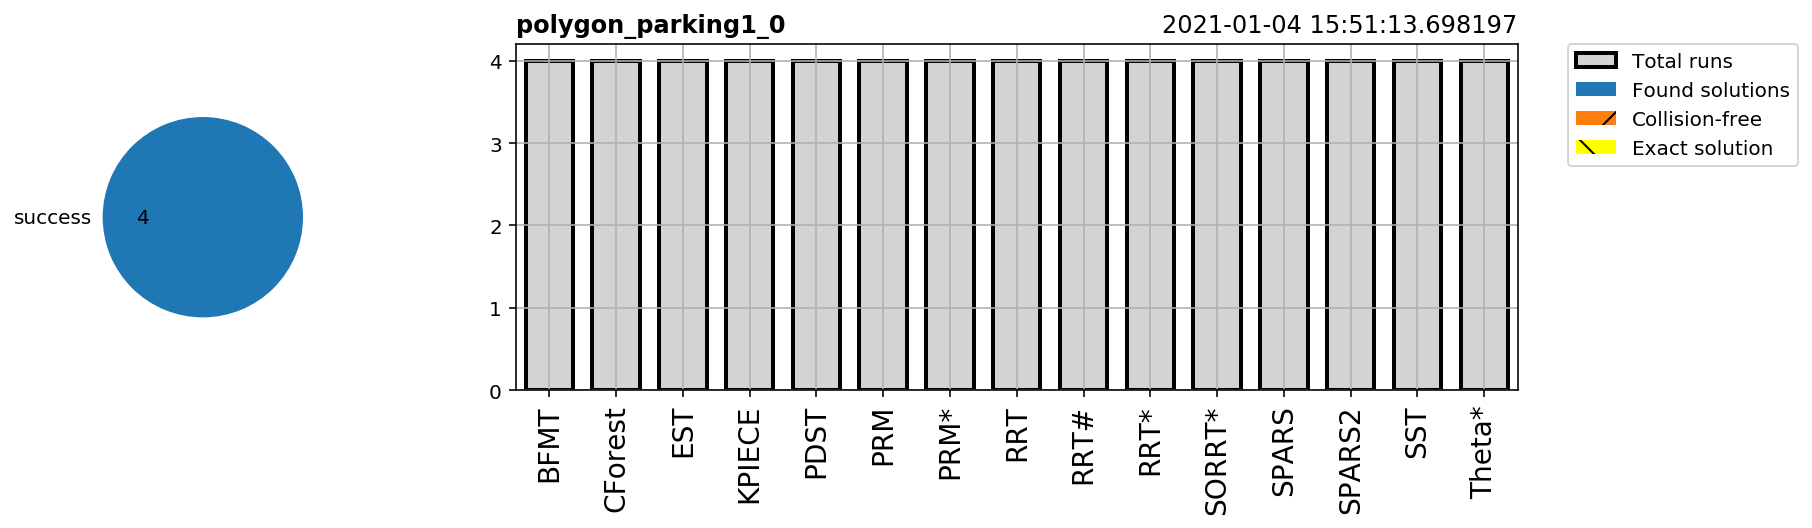

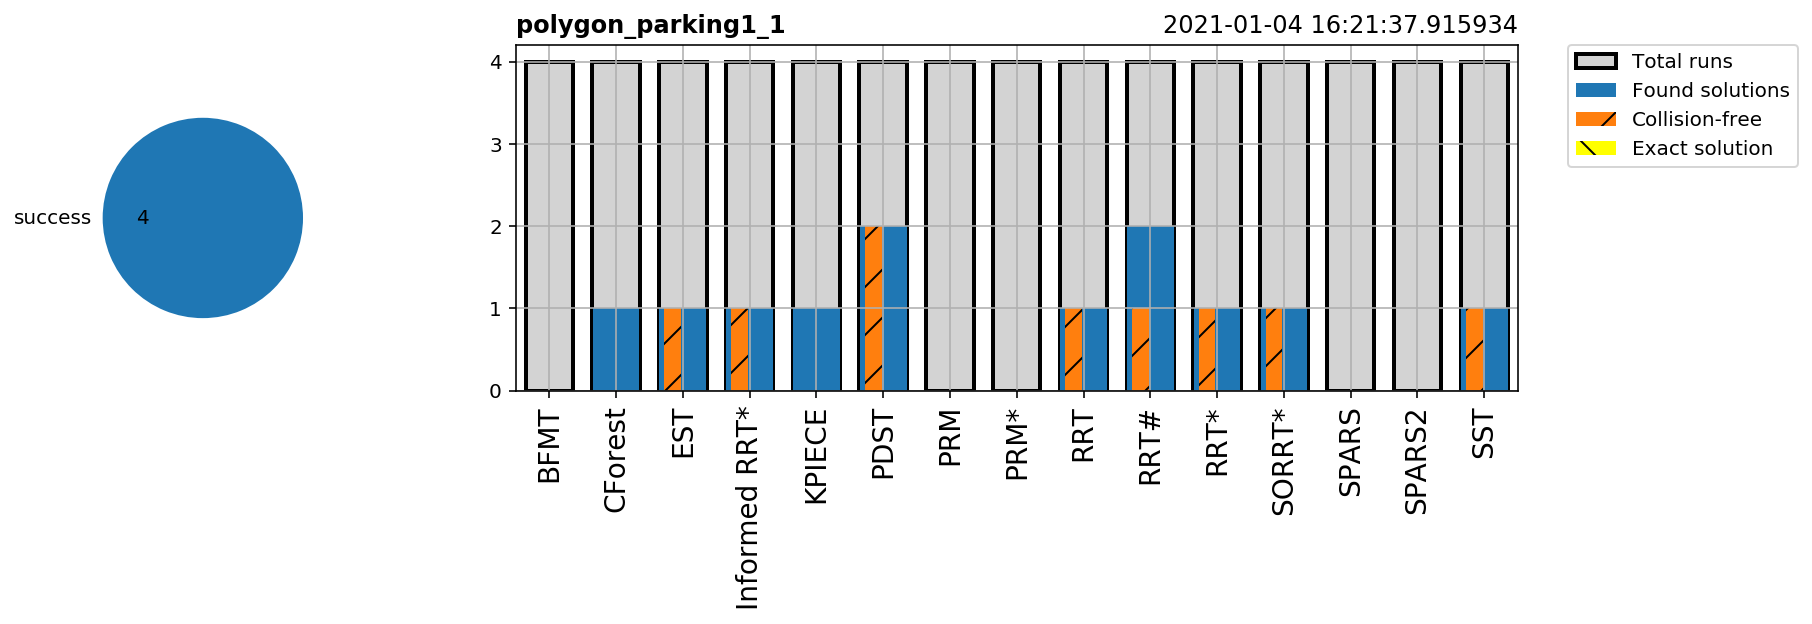

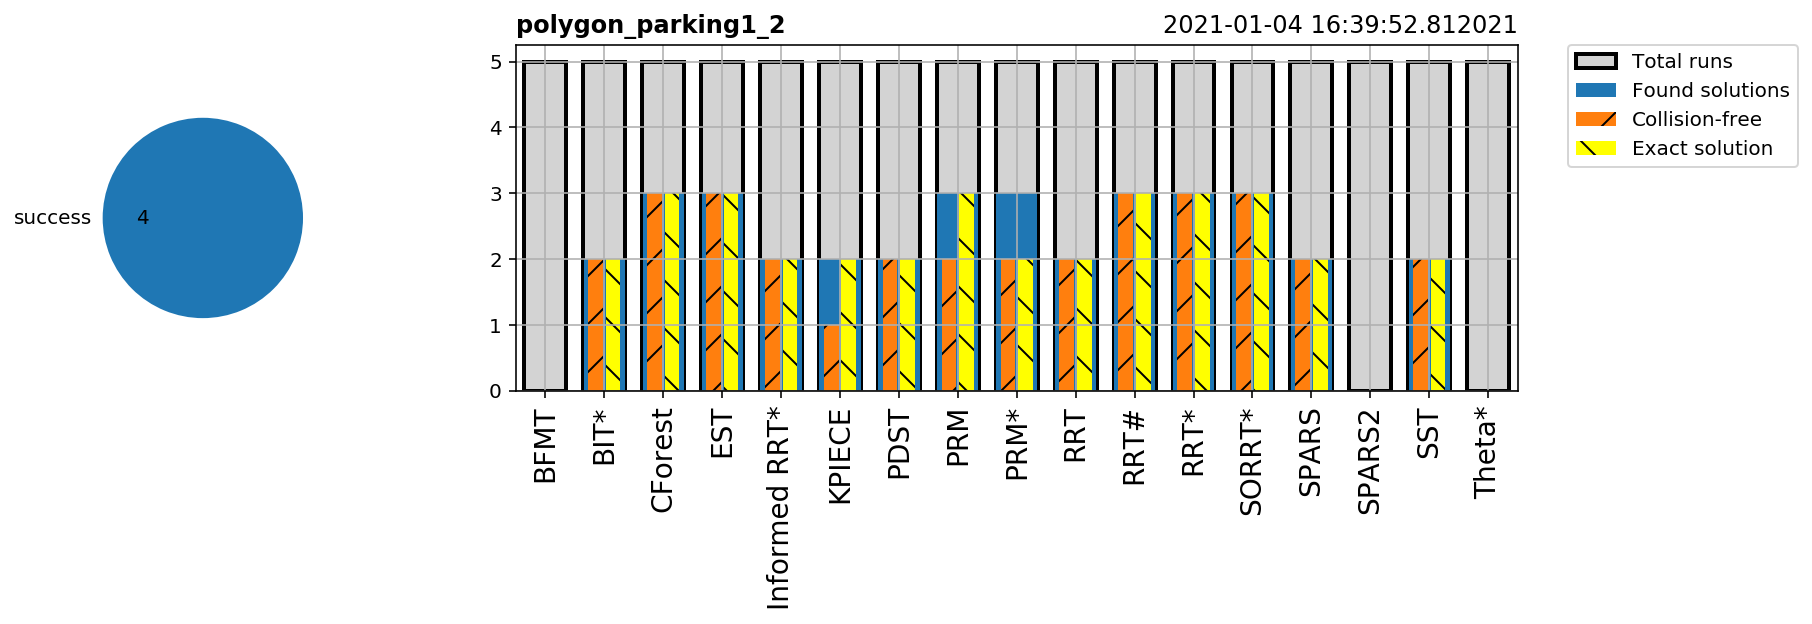

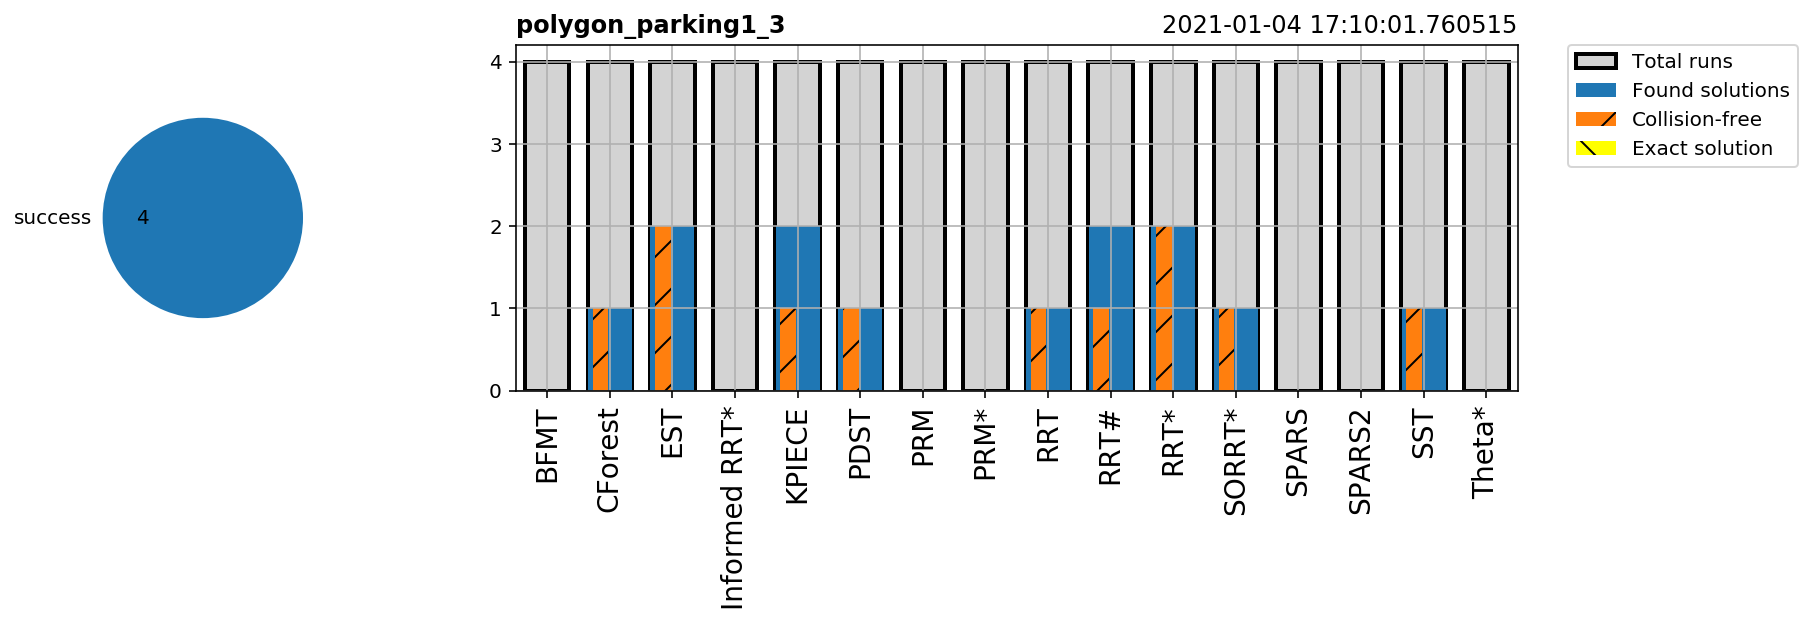

In [7]:
for i, (env, args) in enumerate(scenarios):
    for j, arg in enumerate(args):
        scenario = "%s_%i" % (env, j)
        benchmark_polygon(scenario, *arg)

Plot statistics.

dict_keys(['parking1_0', 'parking1_1', 'parking1_2', 'parking1_3', 'parking1_4'])
Successfully merged [polygon_parking1_0/polygon_parking1_0_0_results.json, polygon_parking1_1/polygon_parking1_1_0_results.json, polygon_parking1_2/polygon_parking1_2_0_results.json, polygon_parking1_3/polygon_parking1_3_0_results.json, polygon_parking1_4/polygon_parking1_4_0_results.json] into parking1_total.json.
Visualizing parking1_total.json...
Successfully merged [] into parking2_total.json.
Visualizing parking2_total.json...
Successfully merged [] into parking3_total.json.
Visualizing parking3_total.json...
Successfully merged [] into warehouse_total.json.
Visualizing warehouse_total.json...


Error while plotting planner statistics: 'NoneType' object is not subscriptable
Error while plotting planner statistics: 'NoneType' object is not subscriptable
Error while plotting planner statistics: 'NoneType' object is not subscriptable
Error while plotting planner statistics: 'NoneType' object is not subscriptable


Successfully merged [polygon_parking1_0/polygon_parking1_0_1_results.json, polygon_parking1_1/polygon_parking1_1_1_results.json, polygon_parking1_2/polygon_parking1_2_1_results.json, polygon_parking1_3/polygon_parking1_3_1_results.json, polygon_parking1_4/polygon_parking1_4_1_results.json] into parking1_total.json.
Visualizing parking1_total.json...
Successfully merged [] into parking2_total.json.
Visualizing parking2_total.json...
Successfully merged [] into parking3_total.json.
Visualizing parking3_total.json...
Successfully merged [] into warehouse_total.json.
Visualizing warehouse_total.json...
Successfully merged [polygon_parking1_0/polygon_parking1_0_2_results.json, polygon_parking1_1/polygon_parking1_1_2_results.json, polygon_parking1_2/polygon_parking1_2_2_results.json, polygon_parking1_3/polygon_parking1_3_2_results.json, polygon_parking1_4/polygon_parking1_4_2_results.json] into parking1_total.json.
Visualizing parking1_total.json...
Successfully merged [] into parking2_total

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
Error while plotting planner statistics: 'NoneType' object is not subscriptable
Error while plotting planner statistics: 'NoneType' object is not subscriptable
Error while plotting planner statistics: 'NoneType' object is not subscriptable
Error while plotting planner statistics: 'NoneType' object is not subscriptable
Error while plotting planner statistics: 'NoneType' object is not subscriptable
Error while plotting planner statistics: 'NoneType' object is not subscriptable
Error while plotting planner statistics: 'NoneType' object is n

Successfully merged [polygon_parking1_0/polygon_parking1_0_3_results.json, polygon_parking1_1/polygon_parking1_1_3_results.json, polygon_parking1_2/polygon_parking1_2_3_results.json, polygon_parking1_3/polygon_parking1_3_3_results.json, polygon_parking1_4/polygon_parking1_4_3_results.json] into parking1_total.json.
Visualizing parking1_total.json...
Successfully merged [] into parking2_total.json.
Visualizing parking2_total.json...
Successfully merged [] into parking3_total.json.
Visualizing parking3_total.json...
Successfully merged [] into warehouse_total.json.
Visualizing warehouse_total.json...


Error while plotting planner statistics: 'NoneType' object is not subscriptable
Error while plotting planner statistics: 'NoneType' object is not subscriptable
Error while plotting planner statistics: 'NoneType' object is not subscriptable
Error while plotting planner statistics: 'NoneType' object is not subscriptable


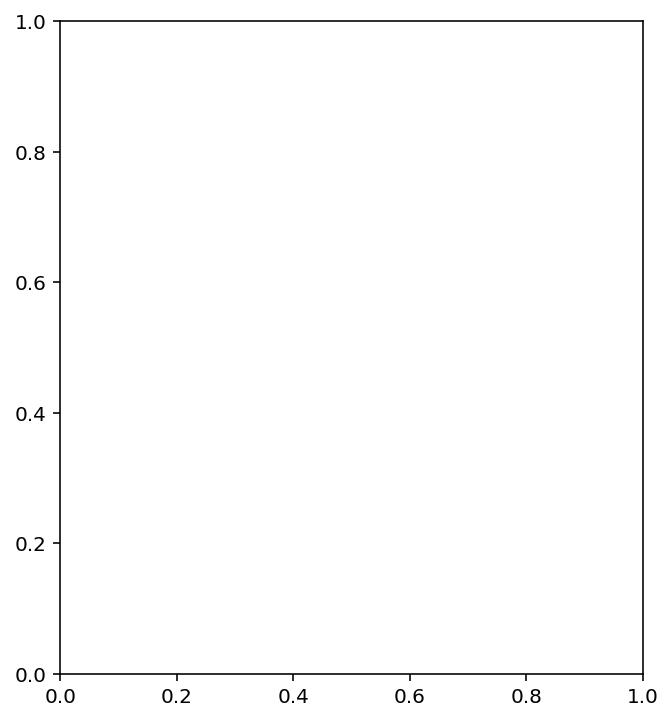

In [8]:
print(pools.keys())
for steer in range(len(steer_function_times)):
    for env, _ in scenarios:
        generate_plots(env, steer)

Visualize trajectories.

In [ ]:
for env, args in scenarios:
    for j in range(1, len(args) + 1):
        suptitle = "Environment: %s   Scenario: %i" % (env, j)
        scenario = "%s_%i" % (env, j)
        visualize_grid("polygon_%s/polygon_%s_0_results.json" % (scenario, scenario),
                       suptitle=suptitle, save_file="%s.pdf" % scenario,
                       plot_every_nth_polygon=10)